<a href="https://colab.research.google.com/github/luuchung/Bayes_AMC/blob/main/ECE225A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

torch.manual_seed(225) # reproducability
sns.set_style('dark')
%matplotlib inline

In [9]:
# This code is motivated from https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb

In [12]:
# Model
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,784)

    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)

    def sample_normal(self,mean,logvar): # Reparameterization trick
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size()))
        z = e.mul(sd).add_(mean)
        return z

    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

def cal_loss(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0)
    return loss

def train(model,optimizer,dataloader,epochs=30):
    losses = []
    for epoch in range(epochs):
        for images,_ in dataloader:
            x_in = Variable(images)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = cal_loss(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses

def visualize_mnist_vae(model,dataloader,num=10):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()

    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

def visualize_encoder(model, dataloader):
    z_means_x, z_means_y, all_labels = [], [], []

    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())

    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z)
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

In [8]:
# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.39MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


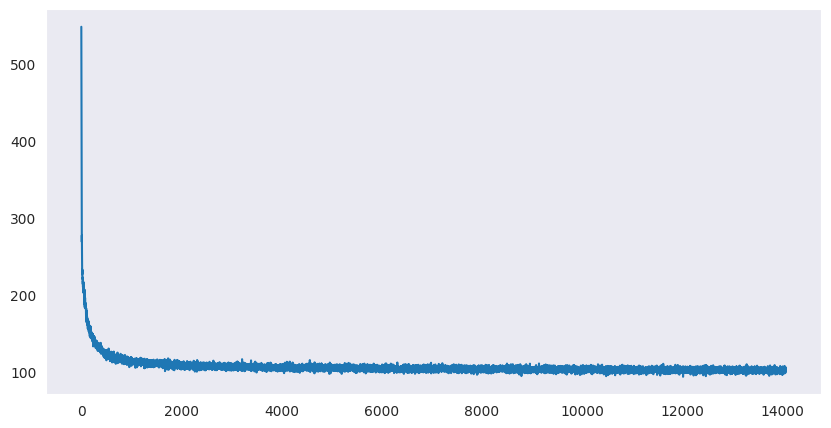

In [13]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters())
train_losses = train(model,optimizer,trainloader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

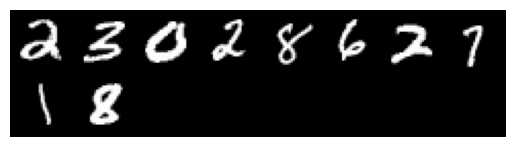

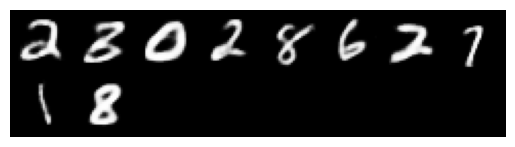

In [18]:
#visualize_mnist_vae(model,testloader)

def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()

images,_ = next(iter(testloader))
images = images[0:10,:,:]
x_in = Variable(images)
x_out,_,_ = model(x_in)
x_out = x_out.data
imshow(make_image_grid(images))
imshow(make_image_grid(x_out))

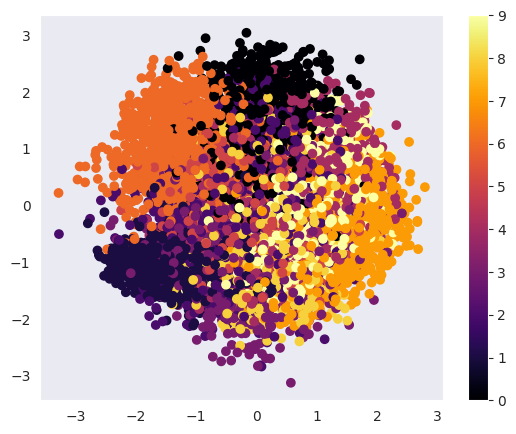

In [19]:
visualize_encoder(model,testloader)

In [23]:
model2 = VAE(latent_dim=2)
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2,optimizer2,trainloader)


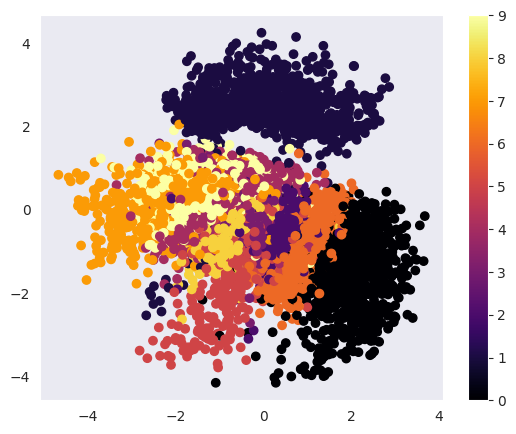

In [24]:
visualize_encoder(model2,testloader)

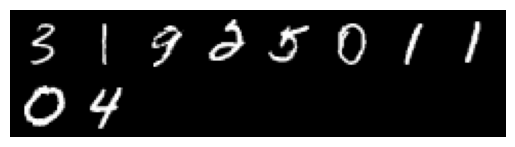

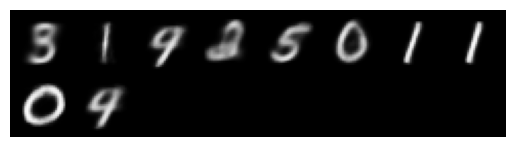

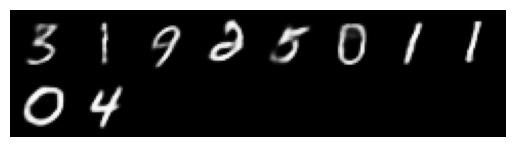

In [27]:
def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()

images,_ = next(iter(testloader))
images = images[0:10,:,:]
x_in = Variable(images)
x_out,_,_ = model2(x_in)
x_out_2,_,_ = model(x_in)
x_out = x_out.data
imshow(make_image_grid(images))
imshow(make_image_grid(x_out))
imshow(make_image_grid(x_out_2))

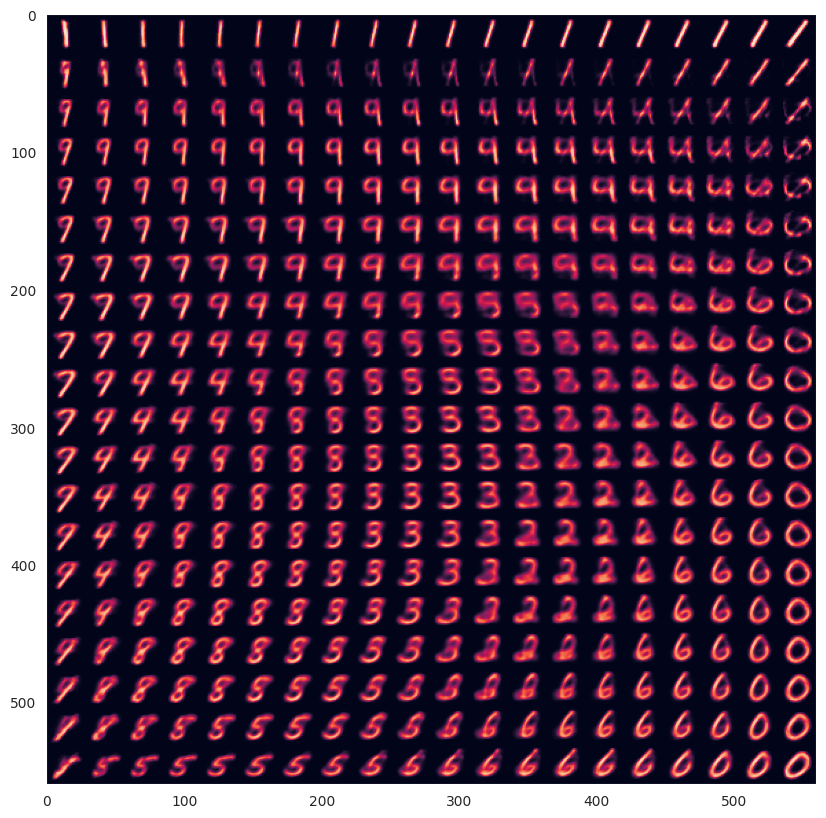

In [26]:
visualize_decoder(model2)